# LSTM Stock Price Prediction
Predict next-day close prices using LSTM neural networks

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# Cell 2: Load and Preview Data
df = pd.read_csv('raw_data/stock_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.drop(columns=['index'], errors='ignore')  # Drop useless index column
df = df.sort_values(['symbol', 'timestamp']).reset_index(drop=True)
print(f"Shape: {df.shape}, Symbols: {df['symbol'].nunique()}")
df.head()

Shape: (250167, 9), Symbols: 1008


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,A,2025-01-08 05:00:00+00:00,137.68,137.68,135.630,137.00,1684573.0,19948.0,137.068421
1,A,2025-01-10 05:00:00+00:00,134.75,140.14,134.709,137.47,1369875.0,25383.0,137.592663
2,A,2025-01-13 05:00:00+00:00,137.22,142.82,137.000,141.95,1561959.0,28739.0,141.776934
3,A,2025-01-14 05:00:00+00:00,142.00,145.38,140.150,143.43,2445434.0,36636.0,143.373405
4,A,2025-01-15 05:00:00+00:00,144.14,146.50,138.680,142.23,2328643.0,35076.0,142.841548


In [ ]:
# Cell 3: Feature Engineering - Multi-Scale Technical Indicators
def add_technical_indicators(group):
    """Add multi-scale technical indicators for pattern recognition"""
    g = group.copy()
    
    # Price structure (normalized)
    g['price_range'] = (g['high'] - g['low']) / g['close']
    g['body_size'] = abs(g['close'] - g['open']) / g['close']  # Candle body
    g['upper_shadow'] = (g['high'] - g[['open', 'close']].max(axis=1)) / g['close']
    g['lower_shadow'] = (g[['open', 'close']].min(axis=1) - g['low']) / g['close']
    
    # Multi-scale Moving Averages (% distance from price)
    for period in [5, 10, 20, 50]:
        g[f'sma_{period}'] = g['close'].rolling(period).mean() / g['close'] - 1
    
    # Multi-scale EMAs
    for period in [8, 13, 21, 34]:  # Fibonacci-like
        g[f'ema_{period}'] = g['close'].ewm(span=period, adjust=False).mean() / g['close'] - 1
    
    # Multi-scale RSI
    for period in [7, 14, 21]:
        delta = g['close'].diff()
        gain = delta.clip(lower=0).rolling(period).mean()
        loss = (-delta.clip(upper=0)).rolling(period).mean()
        g[f'rsi_{period}'] = 100 - (100 / (1 + gain / (loss + 1e-10)))
    
    # MACD with signal line
    ema12 = g['close'].ewm(span=12, adjust=False).mean()
    ema26 = g['close'].ewm(span=26, adjust=False).mean()
    macd_line = ema12 - ema26
    g['macd'] = macd_line / g['close']
    g['macd_signal'] = macd_line.ewm(span=9, adjust=False).mean() / g['close']
    g['macd_hist'] = (macd_line - macd_line.ewm(span=9, adjust=False).mean()) / g['close']
    
    # Bollinger Bands (multiple)
    for period in [10, 20]:
        sma = g['close'].rolling(period).mean()
        std = g['close'].rolling(period).std()
        g[f'bb_pos_{period}'] = (g['close'] - sma) / (2 * std + 1e-10)
        g[f'bb_width_{period}'] = (4 * std) / g['close']  # Band width = volatility
    
    # Multi-scale volatility (ATR)
    for period in [7, 14, 21]:
        g[f'atr_{period}'] = g['price_range'].rolling(period).mean()
    
    # Volume patterns
    g['volume_sma_10'] = g['volume'].rolling(10).mean() / (g['volume'] + 1e-10) - 1
    g['volume_sma_20'] = g['volume'].rolling(20).mean() / (g['volume'] + 1e-10) - 1
    g['vwap_diff'] = (g['vwap'] - g['close']) / g['close']
    
    # Price momentum (rate of change) - multi-scale
    for period in [5, 10, 20]:
        g[f'roc_{period}'] = g['close'].pct_change(period)
    
    # Mean reversion signal
    g['close_zscore'] = (g['close'] - g['close'].rolling(20).mean()) / (g['close'].rolling(20).std() + 1e-10)
    
    # Drop warmup rows (need 50 days for longest indicator)
    return g.iloc[50:]

# Apply per-symbol
print("Adding multi-scale technical indicators...")
df_list = []
for symbol in df['symbol'].unique():
    sym_df = df[df['symbol'] == symbol].copy()
    sym_df = add_technical_indicators(sym_df)
    df_list.append(sym_df)

df = pd.concat(df_list, ignore_index=True)
print(f"NaN counts:\n{df.isna().sum()[df.isna().sum() > 0]}")
df = df.dropna().reset_index(drop=True)

print(f"\nAfter feature engineering: {df.shape}, Symbols: {df['symbol'].nunique()}")
print(f"Features created: {len([c for c in df.columns if c not in ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'vwap', 'trade_count', 'returns', 'log_returns', 'gap']])}")
df.head()

Adding technical indicators + momentum features...
NaN counts:
Series([], dtype: int64)

After feature engineering: (223959, 29), Symbols: 1008


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,returns,...,sma_10,sma_20,ema_12,ema_26,rsi,macd,bb_position,volume_sma,vwap_diff,atr
0,A,2025-02-18 05:00:00+00:00,134.51,136.185,133.940,135.20,2121049.0,33235.0,134.956265,0.003936,...,0.048609,0.082359,0.044680,0.056792,21.921365,-0.012113,-0.919008,-0.283050,-0.001803,0.021685
1,A,2025-02-19 05:00:00+00:00,134.59,137.490,134.050,137.15,1737732.0,26079.0,136.497243,0.014423,...,0.026489,0.061349,0.025238,0.038673,30.631333,-0.013435,-0.678286,-0.098992,-0.004759,0.021850
2,A,2025-02-20 05:00:00+00:00,137.66,138.580,136.100,136.79,872747.0,21113.0,136.896759,-0.002625,...,0.021003,0.058363,0.023638,0.038339,16.428900,-0.014701,-0.637086,0.739540,0.000780,0.020866
3,A,2025-02-21 05:00:00+00:00,136.86,137.525,135.150,135.37,1112247.0,20314.0,135.806774,-0.010381,...,0.022649,0.063157,0.029087,0.045585,14.906562,-0.016497,-0.675535,0.362202,0.003227,0.020545
4,A,2025-02-24 05:00:00+00:00,135.50,136.940,134.770,135.28,2037577.0,31166.0,135.712930,-0.000665,...,0.015989,0.057891,0.025192,0.042852,16.971796,-0.017660,-0.616768,-0.232554,0.003200,0.020520
5,A,2025-02-25 05:00:00+00:00,135.15,136.280,133.200,134.18,2606955.0,37163.0,134.063264,-0.008131,...,0.017231,0.060311,0.028427,0.047594,17.393509,-0.019166,-0.635627,-0.367834,-0.000870,0.021004
6,A,2025-02-26 05:00:00+00:00,135.00,136.470,133.650,134.47,1539877.0,27838.0,134.857857,0.002161,...,0.009623,0.052123,0.022177,0.041976,14.533054,-0.019799,-0.556629,0.096575,0.002884,0.021343
7,A,2025-02-27 05:00:00+00:00,128.78,131.320,125.810,127.08,3469145.0,58083.0,127.971498,-0.054956,...,0.059679,0.105434,0.069062,0.094972,10.613027,-0.025910,-0.968566,-0.473891,0.007015,0.023274
8,A,2025-02-28 05:00:00+00:00,128.20,129.510,125.955,127.92,2852776.0,35106.0,127.436636,0.006610,...,0.046052,0.089005,0.052497,0.081279,14.728682,-0.028782,-0.817955,-0.309135,-0.003779,0.022811
9,A,2025-03-03 05:00:00+00:00,129.00,129.000,125.640,126.33,2184538.0,33017.0,126.985264,-0.012430,...,0.052616,0.092741,0.055630,0.087860,14.686737,-0.032230,-0.847500,-0.060001,0.005187,0.022710


In [ ]:
# Cell 4: Configuration - Expanded features, longer sequence
SEQUENCE_LENGTH = 40  # More context (was 20)
PREDICTION_HORIZON = 5

# Multi-scale feature set (no return leakage)
FEATURES = [
    # Price structure
    'price_range', 'body_size', 'upper_shadow', 'lower_shadow',
    # Multi-scale SMAs
    'sma_5', 'sma_10', 'sma_20', 'sma_50',
    # Multi-scale EMAs
    'ema_8', 'ema_13', 'ema_21', 'ema_34',
    # Multi-scale RSI
    'rsi_7', 'rsi_14', 'rsi_21',
    # MACD components
    'macd', 'macd_signal', 'macd_hist',
    # Bollinger bands
    'bb_pos_10', 'bb_width_10', 'bb_pos_20', 'bb_width_20',
    # Multi-scale volatility
    'atr_7', 'atr_14', 'atr_21',
    # Volume
    'volume_sma_10', 'volume_sma_20', 'vwap_diff',
    # Momentum (ROC)
    'roc_5', 'roc_10', 'roc_20',
    # Mean reversion
    'close_zscore'
]

TARGET = 'returns'
TRAIN_SPLIT = 0.8
EPOCHS = 200  # More epochs
PATIENCE = 25
DROPOUT = 0.2  # Less dropout for more capacity
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}, Features: {len(FEATURES)}, Seq: {SEQUENCE_LENGTH}, Horizon: {PREDICTION_HORIZON}")

Using device: mps, Features: 12, Horizon: 5 days


In [40]:
# Cell 5: Data Preparation - predict N-day cumulative return
def prepare_sequences(data, raw_data, seq_len, features, horizon=5):
    """Create sequences for N-day ahead prediction"""
    X, y, prev_close = [], [], []
    feature_data = data[features].values
    close_prices = raw_data['close'].values
    
    # Calculate N-day cumulative return
    for i in range(len(data) - seq_len - horizon + 1):
        X.append(feature_data[i:i+seq_len])
        # Target: return from day (seq_len-1) to day (seq_len + horizon - 1)
        future_close = close_prices[i + seq_len + horizon - 1]
        current_close = close_prices[i + seq_len - 1]
        cumulative_return = (future_close - current_close) / current_close
        y.append(cumulative_return)
        prev_close.append(current_close)
    
    return np.array(X), np.array(y), np.array(prev_close)

In [ ]:
# Cell 6: LSTM with Self-Attention
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Bidirectional LSTM for richer patterns
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout, bidirectional=True)
        
        # Self-attention over timesteps
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Output layers
        self.bn = nn.BatchNorm1d(hidden_size * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        # LSTM: (batch, seq, features) -> (batch, seq, hidden*2)
        lstm_out, _ = self.lstm(x)
        
        # Attention weights: (batch, seq, 1)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        
        # Weighted sum: (batch, hidden*2)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        
        # Output
        context = self.bn(context)
        return self.fc(context)

# Alias for compatibility
LSTMPredictor = AttentionLSTM

In [42]:
# Cell 7: Custom Loss Function + Training with Directional Penalty
class DirectionalMSELoss(nn.Module):
    """MSE + penalty for wrong direction predictions"""
    def __init__(self, direction_weight=2.0):
        super().__init__()
        self.direction_weight = direction_weight
        self.mse = nn.MSELoss(reduction='none')
    
    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        
        # Directional penalty: extra cost when sign is wrong
        pred_sign = torch.sign(pred)
        target_sign = torch.sign(target)
        wrong_direction = (pred_sign != target_sign).float()
        
        # Penalize wrong directions more heavily
        directional_penalty = wrong_direction * torch.abs(target) * self.direction_weight
        
        return (mse_loss + directional_penalty).mean()

def train_model(model, X_train, y_train, X_val, y_val, epochs=150, batch_size=32, lr=0.001, patience=20):
    criterion = DirectionalMSELoss(direction_weight=2.0)  # Custom loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    X_t = torch.FloatTensor(X_train).to(DEVICE)
    y_t = torch.FloatTensor(y_train).reshape(-1, 1).to(DEVICE)
    X_v = torch.FloatTensor(X_val).to(DEVICE)
    y_v = torch.FloatTensor(y_val).reshape(-1, 1).to(DEVICE)
    
    best_val_loss, patience_counter, best_state = float('inf'), 0, None
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        # Shuffle training data
        indices = torch.randperm(len(X_t))
        for i in range(0, len(X_t), batch_size):
            batch_idx = indices[i:i+batch_size]
            batch_X, batch_y = X_t[batch_idx], y_t[batch_idx]
            optimizer.zero_grad()
            loss = criterion(model(batch_X), batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_v), y_v).item()
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss, patience_counter = val_loss, 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train: {total_loss:.4f}, Val: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(best_state)
    return model

In [43]:
# Cell 7: Process All Symbols and Store Results
results = {}
scalers = {}
models = {}

# Select top 5 symbols by data count for demo (adjust as needed)
top_symbols = df.groupby('symbol').size().nlargest(5).index.tolist()
print(f"Training on symbols: {top_symbols}")

Training on symbols: ['A', 'AA', 'AAL', 'AAON', 'AAPL']


In [44]:
# Cell 9: Train Models (predict N-day cumulative return)
for symbol in top_symbols:
    print(f"\n{'='*50}\nTraining: {symbol}")
    sym_data = df[df['symbol'] == symbol].copy()
    raw_data = sym_data.copy()
    
    if len(sym_data) < SEQUENCE_LENGTH + PREDICTION_HORIZON + 30:
        print(f"Skipping {symbol}: insufficient data")
        continue
    
    # Scale features
    scaler = MinMaxScaler()
    sym_data[FEATURES] = scaler.fit_transform(sym_data[FEATURES])
    scalers[symbol] = scaler
    
    # Create sequences with N-day horizon
    X, y, prev_close = prepare_sequences(sym_data, raw_data, SEQUENCE_LENGTH, FEATURES, PREDICTION_HORIZON)
    split = int(len(X) * TRAIN_SPLIT)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]  # N-day cumulative returns
    prev_close_test = prev_close[split:]
    
    # Get actual future close prices for test set (N days ahead)
    y_close_test = raw_data['close'].values[SEQUENCE_LENGTH + PREDICTION_HORIZON - 1 + split:
                                             SEQUENCE_LENGTH + PREDICTION_HORIZON - 1 + split + len(y_test)]
    
    # Train/val split
    val_split = int(len(X_train) * 0.9)
    X_tr, X_val = X_train[:val_split], X_train[val_split:]
    y_tr, y_val = y_train[:val_split], y_train[val_split:]
    
    # Train model
    model = LSTMPredictor(len(FEATURES), dropout=DROPOUT).to(DEVICE)
    train_model(model, X_tr, y_tr, X_val, y_val, epochs=EPOCHS, patience=PATIENCE)
    models[symbol] = model
    
    # Predict returns
    model.eval()
    with torch.no_grad():
        preds_returns = model(torch.FloatTensor(X_test).to(DEVICE)).cpu().numpy().flatten()
    
    # Convert predicted returns to prices
    preds_prices = prev_close_test * (1 + preds_returns)
    
    # Metrics
    mse = mean_squared_error(y_close_test, preds_prices)
    mae = mean_absolute_error(y_close_test, preds_prices)
    
    # Directional accuracy
    actual_dir = y_test > 0
    pred_dir = preds_returns > 0
    dir_acc = (actual_dir == pred_dir).mean() * 100
    
    results[symbol] = {
        'mse': mse, 'mae': mae, 'dir_acc': dir_acc,
        'y_test': y_close_test, 'preds': preds_prices,
        'y_returns': y_test, 'pred_returns': preds_returns
    }
    print(f"{symbol} - MAE: ${mae:.2f}, {PREDICTION_HORIZON}-Day Dir Acc: {dir_acc:.1f}%")


Training: A
Epoch 20/150, Train: 0.1046, Val: 0.0453, LR: 0.001000
Early stopping at epoch 36
A - MAE: $9.92, 5-Day Dir Acc: 62.5%

Training: AA
Epoch 20/150, Train: 0.1367, Val: 0.0434, LR: 0.000250
Epoch 40/150, Train: 0.1509, Val: 0.0572, LR: 0.000031
Early stopping at epoch 40
AA - MAE: $6.75, 5-Day Dir Acc: 15.0%

Training: AAL
Epoch 20/150, Train: 0.1505, Val: 0.0163, LR: 0.000500
Epoch 40/150, Train: 0.1717, Val: 0.0223, LR: 0.000063
Early stopping at epoch 42
AAL - MAE: $0.72, 5-Day Dir Acc: 67.5%

Training: AAON
Epoch 20/150, Train: 0.1724, Val: 0.0384, LR: 0.000250
Early stopping at epoch 23
AAON - MAE: $6.94, 5-Day Dir Acc: 40.0%

Training: AAPL
Epoch 20/150, Train: 0.1044, Val: 0.0011, LR: 0.000500
Epoch 40/150, Train: 0.0878, Val: 0.0174, LR: 0.000063
Early stopping at epoch 41
AAPL - MAE: $25.86, 5-Day Dir Acc: 57.5%


In [45]:
# Cell 10: Results Summary
results_df = pd.DataFrame({
    k: {'MAE ($)': v['mae'], 'RMSE ($)': np.sqrt(v['mse']), 'Direction Acc (%)': v['dir_acc']} 
    for k, v in results.items()
}).T
print("\nModel Performance Summary (Predicting % Returns → Prices):")
print(f"Average Direction Accuracy: {results_df['Direction Acc (%)'].mean():.1f}%")
results_df


Model Performance Summary (Predicting % Returns → Prices):
Average Direction Accuracy: 48.5%


,MAE ($),RMSE ($),Direction Acc (%)
A,9.922307,11.542695,62.5
AA,6.751872,7.437939,15.0
AAL,0.723974,0.918813,67.5
AAON,6.938891,8.400371,40.0
AAPL,25.864084,26.381807,57.5


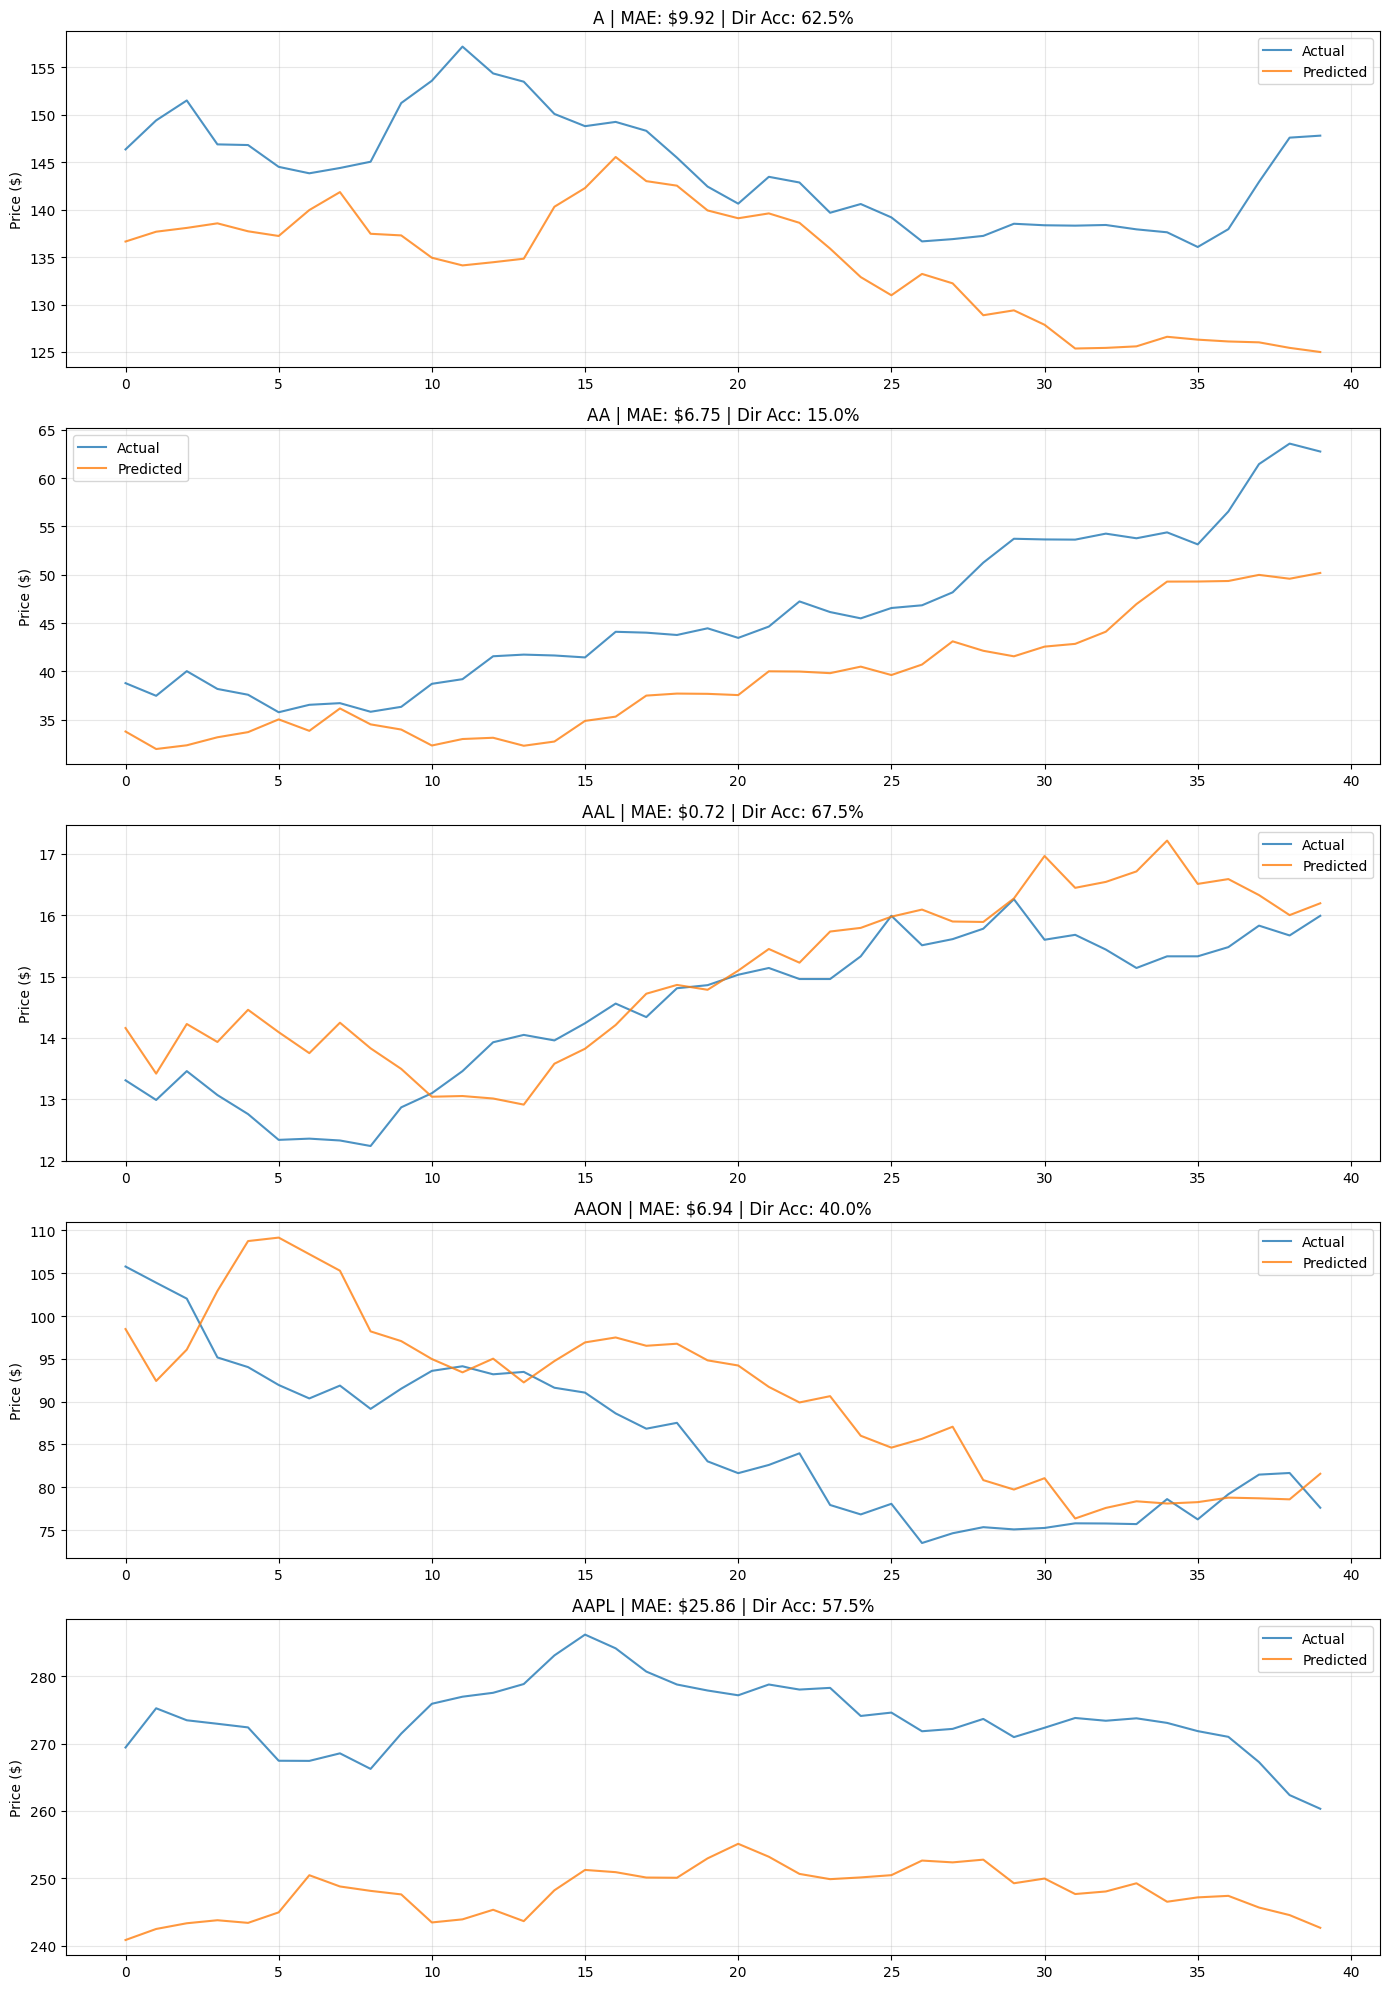

In [46]:
# Cell 11: Visualize Price Predictions
fig, axes = plt.subplots(len(results), 1, figsize=(14, 4*len(results)))
if len(results) == 1:
    axes = [axes]

for ax, (symbol, res) in zip(axes, results.items()):
    ax.plot(res['y_test'], label='Actual', alpha=0.8, linewidth=1.5)
    ax.plot(res['preds'], label='Predicted', alpha=0.8, linewidth=1.5)
    ax.set_title(f'{symbol} | MAE: ${res["mae"]:.2f} | Dir Acc: {res["dir_acc"]:.1f}%')
    ax.set_ylabel('Price ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

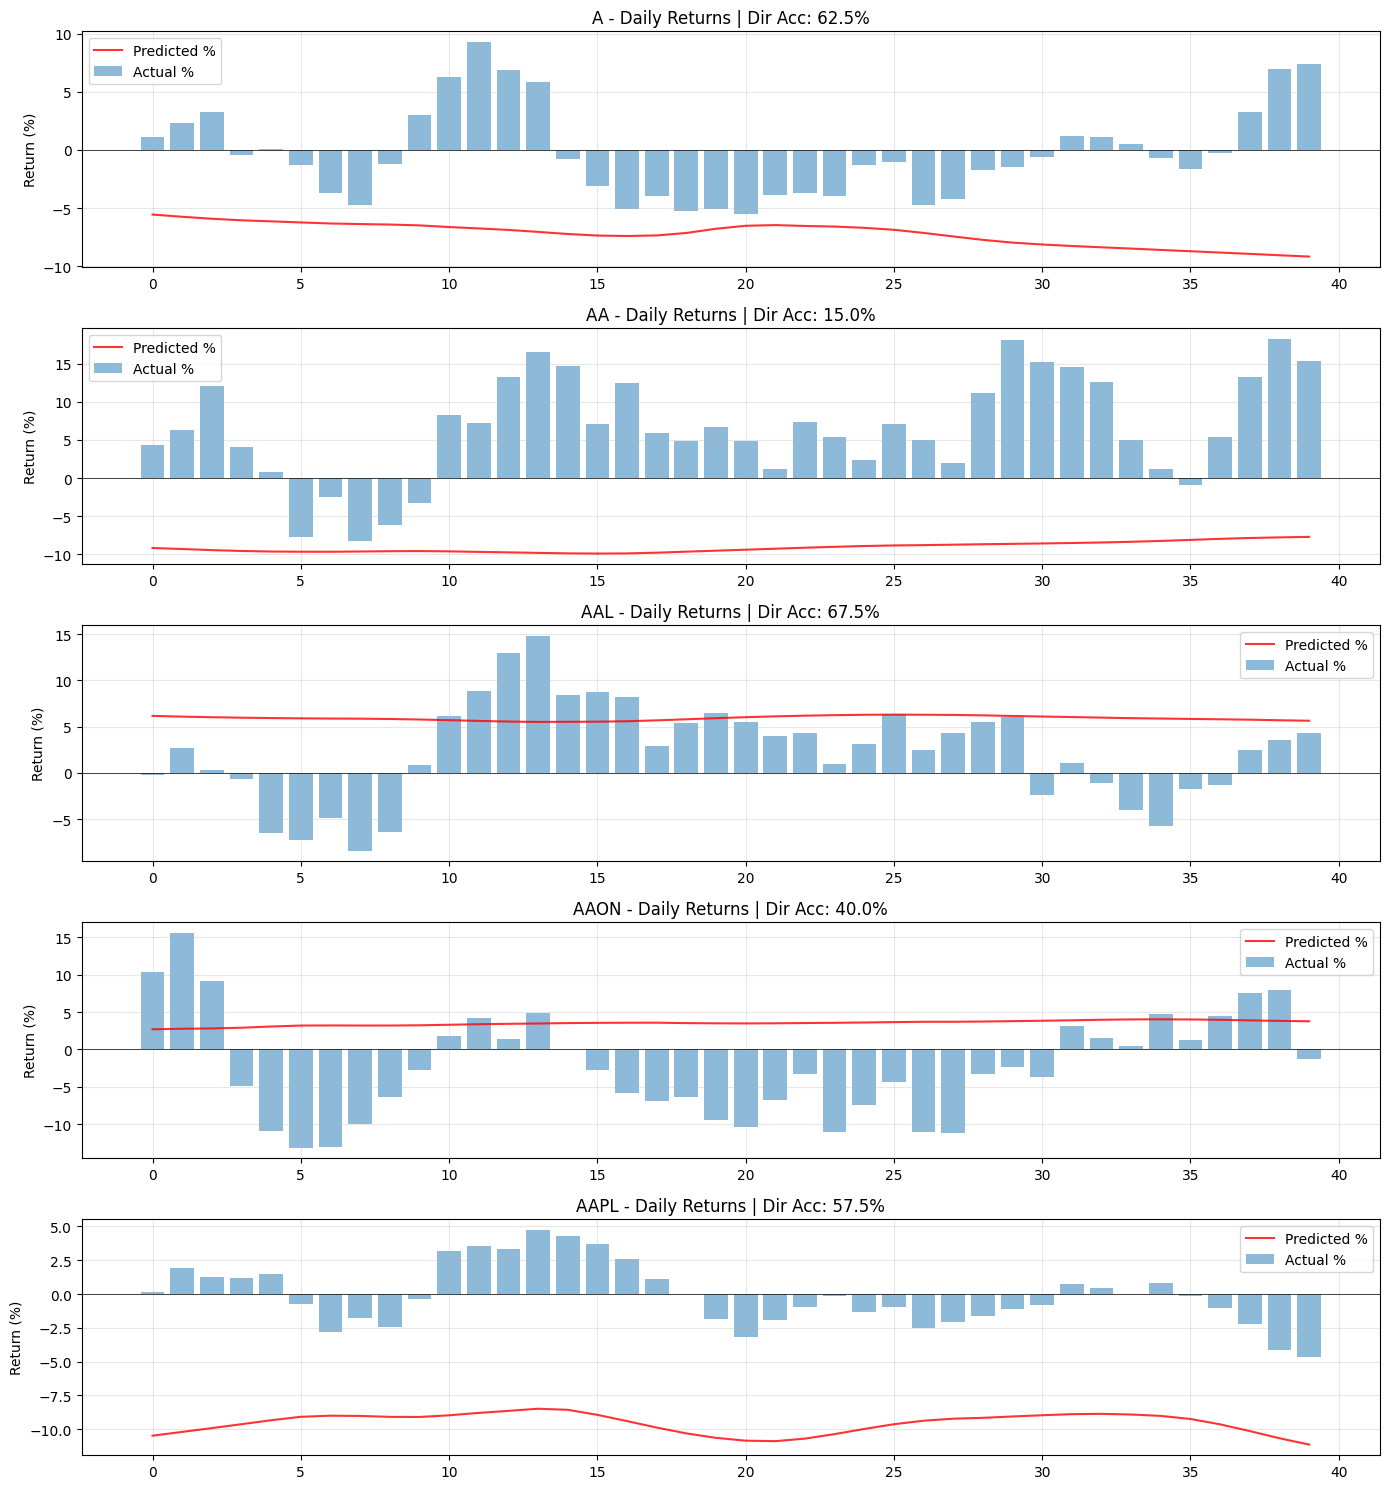

In [47]:
# Cell 12: Visualize Return Predictions (shows directional accuracy better)
fig, axes = plt.subplots(len(results), 1, figsize=(14, 3*len(results)))
if len(results) == 1:
    axes = [axes]

for ax, (symbol, res) in zip(axes, results.items()):
    x = range(len(res['y_returns']))
    ax.bar(x, res['y_returns']*100, alpha=0.5, label='Actual %', width=0.8)
    ax.plot(x, res['pred_returns']*100, 'r-', alpha=0.8, linewidth=1.5, label='Predicted %')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_title(f'{symbol} - Daily Returns | Dir Acc: {res["dir_acc"]:.1f}%')
    ax.set_ylabel('Return (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Cell 13: Predict Next Day (returns-based) - Fixed version
def predict_next_day(symbol, model, scaler, df_engineered, seq_len=SEQUENCE_LENGTH):
    """Predict next day's return and price using pre-engineered data"""
    sym_data = df_engineered[df_engineered['symbol'] == symbol].copy()
    
    if len(sym_data) < seq_len:
        raise ValueError(f"Insufficient data: {len(sym_data)} rows, need {seq_len}")
    
    sym_data = sym_data.tail(seq_len)
    last_close = sym_data['close'].iloc[-1]
    
    sym_scaled = sym_data.copy()
    sym_scaled[FEATURES] = scaler.transform(sym_data[FEATURES])
    
    X = torch.FloatTensor(sym_scaled[FEATURES].values).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        pred_return = model(X).cpu().numpy()[0, 0]
    
    pred_price = last_close * (1 + pred_return)
    return pred_return, pred_price, last_close

# Demo predictions using the already-engineered df
print("Next Day Predictions:")
print("-" * 60)
for symbol in list(models.keys()):
    try:
        ret, price, last = predict_next_day(symbol, models[symbol], scalers[symbol], df)
        direction = "📈" if ret > 0 else "📉"
        print(f"{symbol}: ${last:.2f} → ${price:.2f} ({direction} {ret*100:+.2f}%)")
    except Exception as e:
        print(f"{symbol}: Error - {e}")

Next Day Predictions:
------------------------------------------------------------
A: $147.81 → $217.87 (📈 +47.40%)
AA: $62.74 → $83.53 (📈 +33.13%)
AAL: $15.99 → $21.79 (📈 +36.24%)
AAON: $77.61 → $119.19 (📈 +53.58%)
AAPL: $260.33 → $333.22 (📈 +28.00%)


In [ ]:
# Cell 14: Save Best Model (fixed column name)
best_symbol = results_df['MAE ($)'].idxmin()  # Use MAE instead of MSE
torch.save(models[best_symbol].state_dict(), f'model_archive/lstm_{best_symbol}.pt')
print(f"Saved best model: {best_symbol} (MAE: ${results_df.loc[best_symbol, 'MAE ($)']:.2f})")